# 6-2. **Neural Network**
We are going to implement a Neural Network for identifying animal species using features of animals.

In [7]:
import torch
import numpy as np

Let's say we have two features that represent each:
1. Does animal has hair?
2. Does animal has feather?

We would like to predict whether the animal is bird, mammal, or other.


In [8]:
# [Hair, Feather]
x_data = np.array([[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])
x_data_torch = torch.from_numpy(x_data).float()  # You need to transform the data into Torch data type to be used in Pytorch
print(x_data_torch) # try print if you want to see the details

y_data = np.array([0, 1, 2, 0, 0, 2]) # 0: Other, 1: Mammal, 2: Bird
y_data_torch = torch.from_numpy(y_data)
print(y_data_torch) # try print if you want to see the details

# number of input (features), 2 - Hair, Feather
num_input = 2
# number of output (classes), 3 - Other, Mammal, Bird
num_classes = 3

tensor([[0., 0.],
        [1., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 1.]])
tensor([0, 1, 2, 0, 0, 2])


## No hidden layer with Manual Parameter Update

Build a classification model without hidden layer.
We manually update parameters (weight and bias) in this example.

In [9]:
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Initialize Weight and Bias manually, and setup the gradient
W1 = Variable(torch.randn(num_input, num_classes).float(), requires_grad=True)
B1 = Variable(torch.randn(num_classes).float(), requires_grad=True)

# Learning Rate - determines the step size at each iteration while moving toward a minimum of a loss function
learning_rate = 0.01
# Epoch - A measure of the number of times all of the training vectors are used once to update the weights.
number_of_epochs = 1000 # try 2000 epochs and see how it goes

for epoch in range(number_of_epochs):
    # forward propagataion - the calculation and storage of intermediate variables (incl. outputs) from the input layer to the output layer
    z = torch.add(torch.matmul(x_data_torch, W1), B1)
    # softmax changes each value to have between 0 and 1, and all values will add up to 1
    # i.e. [8.04, 2.76, -6.52] -> [0.53, 0.24, 0.23]
    # log_softmax applies logarithm after softmax.
    # softmax: exp(x_i) / exp(x).sum() and log_softmax: log(exp(x_i) / exp(x).sum())
    # log_softmax essential does log(softmax(x)), but the practical implementation is different and more efficient
    # https://pytorch.org/docs/master/nn.html?highlight=log_softmax#torch.nn.LogSoftmax
    log_softmax = F.log_softmax(z, dim=1)

    # calculate the loss
    loss = F.nll_loss(log_softmax, y_data_torch)

    # back propagation
    loss.backward() # calculate gradient
    with torch.no_grad(): # When doing back propagation, do not accumalte gradient
        W1.data -= learning_rate*W1.grad.data # Gradient descent
        B1.data -= learning_rate*B1.grad.data
    W1.grad.data.zero_() # reset the gradient
    B1.grad.data.zero_()

    if epoch % 200 == 199:
        with torch.no_grad(): # prediction section does not require gradient
            pred_outputs = torch.add(torch.matmul(x_data_torch, W1), B1)
            predicted = torch.argmax(pred_outputs, 1)
            train_acc = accuracy_score(predicted.numpy(), y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss, train_acc))

### Result
print('Predicted :', predicted.numpy())
print('Answer :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.7402, train_acc: 0.667
Epoch: 400, loss: 0.5971, train_acc: 0.833
Epoch: 600, loss: 0.5110, train_acc: 0.833
Epoch: 800, loss: 0.4466, train_acc: 1.000
Epoch: 1000, loss: 0.3956, train_acc: 1.000
Predicted : [0 1 2 0 0 2]
Answer : [0 1 2 0 0 2]
Accuracy : 1.00


## No hidden layer with the Optimizer


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Build a neural network model rather than initializing the parameters manually
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_input, num_classes) # This coresponds to W1,B1

    def forward(self, x):
        x = self.linear(x)
        return x

# get the model
net = Net()

# learning rate
learning_rate = 0.01

# calculate loss by function. The negative log likelihood loss.
criterion = nn.NLLLoss()

# Define the optimizer
# Pass the model parameters to be updated, and setup the learning rate when calling optim.SGD
# Please find the detailed information about the SGD optimizer in PyTorch (https://pytorch.org/docs/stable/optim.html).
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

#epochs
no_of_epochs = 1000

# Every epoch, the model will be modified by the given learning rate
for epoch in range(no_of_epochs):
    # get the input and label
    inputs = x_data_torch
    labels = y_data_torch

    # training the model
    net.train()

    # set the gradients to zero
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(F.log_softmax(outputs, dim=1), labels)
    loss.backward()
    optimizer.step() # back propagation

    if epoch % 200 == 199: # print every 200 epochs
        net.eval() # we are using the model to predict here
        pred_outputs = net(inputs)
        predicted = torch.argmax(outputs, 1)
        train_acc = accuracy_score(predicted.numpy(), y_data)
        print('%d, loss: %.3f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))


print('Finished Training')

### Result
net.eval()
pred_outputs = net(inputs)
predicted = torch.argmax(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Answer :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.831, train_acc: 0.667
400, loss: 0.691, train_acc: 0.833
600, loss: 0.592, train_acc: 0.833
800, loss: 0.516, train_acc: 1.000
1000, loss: 0.455, train_acc: 1.000
Finished Training
Predicted : [0 1 2 0 0 2]
Answer : [0 1 2 0 0 2]
Accuracy : 1.00


## Hidden Layer with Manual Parameter Update

In [11]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# you can find the comment and explanation in the section - no hidden layer, manual parameter update section

# number of neurons in hidden layer,
n_hidden_1 = 5

# [Input(Features), Output(number of neurons in hidden layer)]
W1 = Variable(torch.randn(2, n_hidden_1).float(), requires_grad=True)
# Let Hidden Layer Bias the number of output candidates, which is 5 (number of neurons in hidden layer).
B1 = Variable(torch.randn(n_hidden_1).float(), requires_grad=True)
# [Input(number of neurons in hidden layer), Output(Classes)]
Wout = Variable(torch.randn(n_hidden_1, num_classes).float(), requires_grad=True)
# Let Bias the number of output candidates, which is 3 (number of classes).
Bout = Variable(torch.randn(num_classes).float(), requires_grad=True)

learning_rate = 0.01
no_of_epochs = 1000

for epoch in range(1000):
    z1 = torch.add(torch.matmul(x_data_torch, W1), B1)
    Zout = torch.add(torch.matmul(F.relu(z1), Wout), Bout)

    output = F.log_softmax(Zout, dim=1)
    loss = F.nll_loss(output, y_data_torch)

    loss.backward()
    with torch.no_grad():
        W1.data -= learning_rate*W1.grad.data
        B1.data -= learning_rate*B1.grad.data
        Wout.data -= learning_rate*Wout.grad.data
        Bout.data -= learning_rate*Bout.grad.data

    W1.grad.data.zero_()
    B1.grad.data.zero_()
    Wout.grad.data.zero_()
    Bout.grad.data.zero_()

    if epoch % 200 == 199:
        with torch.no_grad():
            z1 = torch.add(torch.matmul(x_data_torch, W1), B1)
            Zout = torch.add(torch.matmul(F.relu(z1), Wout), Bout)
            predicted = torch.argmax(Zout, 1)
            train_acc = accuracy_score(predicted.numpy(), y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))
print('Finished')
### Result
print('Predicted :', predicted.numpy())
print('Answer :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.5453, train_acc: 0.833
Epoch: 400, loss: 0.3272, train_acc: 1.000
Epoch: 600, loss: 0.2378, train_acc: 1.000
Epoch: 800, loss: 0.1804, train_acc: 1.000
Epoch: 1000, loss: 0.1424, train_acc: 1.000
Finished
Predicted : [0 1 2 0 0 2]
Answer : [0 1 2 0 0 2]
Accuracy : 1.00


## Hidden Layer with the Optimizer


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# you can find the comment and explanation in the section - no hidden layer with the optimizer section
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(num_input, n_hidden_1)
        self.linear2 = nn.Linear(n_hidden_1, num_classes)

    def forward(self, x):
        z1 = self.linear1(x)
        Zout = self.linear2(F.relu(z1))
        return Zout

net = Net()

learning_rate = 0.01
# If you apply Pytorch’s CrossEntropyLoss to your output layer,
# you get the same result as applying Pytorch’s NLLLoss to a LogSoftmax layer added after your original output layer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)


from sklearn.metrics import accuracy_score

for epoch in range(2000): # loop over the dataset multiple times

    # get the inputs
    inputs = x_data_torch
    labels = y_data_torch

    net.train()
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels) # We don't need to calcualte logsoftmax here
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 200 == 199: # print every 200 epochs
        net.eval()
        pred_outputs = net(inputs)
        predicted = torch.argmax(outputs, 1)
        train_acc = accuracy_score(predicted.numpy(), y_data)
        print('%d, loss: %.4f, train_acc: %.4f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

### Result
pred_outputs = net(inputs)
_, predicted = torch.max(outputs, 1)
print('Predicted :', predicted.numpy())
print('Answer :', y_data)

train_acc = accuracy_score(predicted.numpy(), y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.7695, train_acc: 0.8333
400, loss: 0.6202, train_acc: 0.8333
600, loss: 0.5085, train_acc: 0.8333
800, loss: 0.4283, train_acc: 0.8333
1000, loss: 0.3589, train_acc: 1.0000
1200, loss: 0.2967, train_acc: 1.0000
1400, loss: 0.2428, train_acc: 1.0000
1600, loss: 0.1984, train_acc: 1.0000
1800, loss: 0.1632, train_acc: 1.0000
2000, loss: 0.1358, train_acc: 1.0000
Finished Training
Predicted : [0 1 2 0 0 2]
Answer : [0 1 2 0 0 2]
Accuracy : 1.00


## Word2Vec on Pytorch
Let's try to implement Word2Vec with Neural Network with Pytorch

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# raw data - setences
sentences = ['he likes cat',
             'he likes dog',
             'he likes animal',
             'dog cat animal',
             'she likes cat',
             'she dislikes dog',
             'cat likes fish',
             'cat likes milk',
             'dog likes bone',
             'dog dislikes fish',
             'dog likes milk',
             'she likes movie',
             'she likes music',
             'he likes game',
             'he likes movie',
             'cat dislikes dog']

word_sequence = ' '.join(sentences).split()
# convert all sentences to unique word list
word_list = ' '.join(sentences).split()
word_list = list(set(word_list))

# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# Making window size 1 skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # skipgrams - (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


In [14]:
voc_size = len(word_list)

# prepare random batch from skip-gram - we do not have enought data so we randomly select data
def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        input_temp = [0]*voc_size
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(data[i][1])  # context word

    return np.array(random_inputs), np.array(random_labels)


learning_rate = 0.1
batch_size = 10
embedding_size = 2
no_of_epochs = 5000

In [15]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

W1 = Variable(torch.randn(voc_size, embedding_size).float(), requires_grad=True)
Wout = Variable(torch.randn(embedding_size, voc_size).float(), requires_grad=True)

for epoch in range(no_of_epochs):

    inputs,labels = prepare_batch(skip_grams, batch_size) # make batch every epoch
    inputs_torch = torch.from_numpy(inputs).float()
    labels_torch = torch.from_numpy(labels)

    hidden = torch.matmul(inputs_torch ,W1)
    out = torch.matmul(hidden,Wout)

    output = F.log_softmax(out,dim=1)
    loss = F.nll_loss(output, labels_torch)

    loss.backward()
    with torch.no_grad():
        W1.data -= learning_rate*W1.grad.data
        Wout.data -= learning_rate*Wout.grad.data
    W1.grad.data.zero_()
    Wout.grad.data.zero_()

    if epoch % 500 == 499:
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))

Epoch: 500, loss: 1.6465
Epoch: 1000, loss: 2.0201
Epoch: 1500, loss: 2.1430
Epoch: 2000, loss: 2.0949
Epoch: 2500, loss: 1.7040
Epoch: 3000, loss: 2.3579
Epoch: 3500, loss: 1.5822
Epoch: 4000, loss: 1.9413
Epoch: 4500, loss: 1.7161
Epoch: 5000, loss: 2.0496


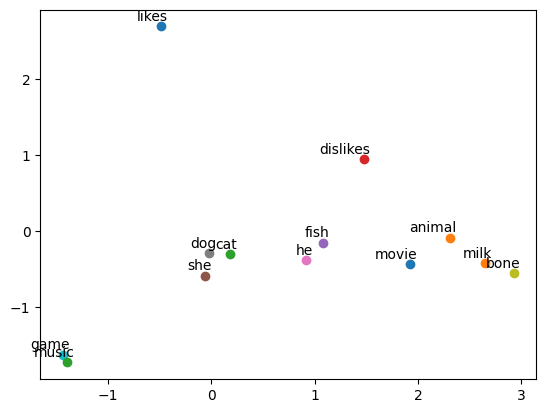

In [16]:
trained_embeddings = W1.data.numpy()
### Visualize result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, ' : ', x, ' ' , y) # please see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

# Exercise

In the tutorial, we learned how to train a word2vec skip-gram model in pytorch, and we manually updates the parameters (weights) in it.

In this exercise, please use the 'NN Model' and the 'Optimizer' (that we learned in the above sections) to train a word2vec skip-gram model.

Note: The embedding size should 2. The code for the preprocessing and the hyperparameter setup are provided. Have fun!




In [ ]:
#preprocess and hyperparameters

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# raw data - setences
sentences = ['he likes cat',
             'he likes dog',
             'he likes animal',
             'dog cat animal',
             'she likes cat',
             'she dislikes dog',
             'cat likes fish',
             'cat likes milk',
             'dog likes bone',
             'dog dislikes fish',
             'dog likes milk',
             'she likes movie',
             'she likes music',
             'he likes game',
             'he likes movie',
             'cat dislikes dog']

# convert all sentences to unique word list
word_sequence = ' '.join(sentences).split()
word_list = ' '.join(sentences).split()
word_list = list(set(word_list))

# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# Making window size 1 skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # skipgrams - (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# prepare random batch from skip-gram - we do not have enought data so we randomly select data
def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        input_temp = [0]*voc_size
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(data[i][1])  # context word

    return np.array(random_inputs), np.array(random_labels)

#hyperparameters
voc_size = len(word_list)
learning_rate = 0.1
batch_size = 10
embedding_size = 2

In [ ]:
# Please include the required libraries

import torch
import torch.nn as nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        #You need to use 'bias=False' when you define Linear functions
        #***************put your code here***************

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

skip_gram_model = SkipGram()
criterion = nn.CrossEntropyLoss() #please note we are using 'CrossEntropyLoss' here
optimizer = optim.SGD(skip_gram_model.parameters(), lr=learning_rate)

for epoch in range(5000):

    inputs,labels = prepare_batch(skip_grams, batch_size)
    inputs_torch = torch.from_numpy(inputs).float()
    labels_torch = torch.from_numpy(labels)

    #***************put your code here***************
    # 1. zero grad
    # 2. forward propagation
    # 3. calculate loss
    # 4. back propagation

    if epoch % 500 == 499:
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))

#Hint: you can refer Lab 6-1 to know how to get the weight from a Model Linear layer
weight1 = #***************put your code here***************
trained_embeddings = weight1.detach().T.numpy()


In [ ]:
### Visualize result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, ' : ', x, ' ' , y)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()